In [1]:
%matplotlib inline
from dataclasses import dataclass

import rospy
import matplotlib.pyplot as plt
import numpy as np
import rosbag
import scipy.optimize
from angles import normalize_angle, shortest_angular_distance
from numpy import sin, cos
from tf.transformations import translation_matrix, quaternion_matrix, inverse_matrix, translation_from_matrix, \
    euler_from_matrix, euler_matrix, identity_matrix
from tf2_ros import ExtrapolationException, Buffer, LookupException


# bag_file_path = '/home/ramon/2021-02-26-13-55-27_filtered.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-40-17_error.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-29-35_tuned.bag'
# bag_file_path = '/home/ramon/2021-03-05-13-43-38_linear_error.bag'
bag_file_path = '/home/ramon/2021-03-05-14-30-29_angle_error.bag'


class BagTfTransformer(object):
    def __init__(self, bag):
        msgs = [msg for _, msg, _ in bag.read_messages(topics=['/tf'])]
        tfs = [tf for msg in msgs for tf in msg.transforms]
        
        ts = [tf.header.stamp for tf in tfs]        
        self.buffer = Buffer(cache_time=max(ts) - min(ts), debug=False)
        
        for tf in tfs:
            self.buffer.set_transform(tf, 'rosbag')
        
    def lookup_transform(self, target_frame, source_frame, time):
        return self.buffer.lookup_transform(target_frame, source_frame, time)


bag = rosbag.Bag(bag_file_path)
bag_transformer = BagTfTransformer(bag)


for _, msg, _ in bag.read_messages(topics=['/scan']):
    try:
        ground_truth = bag_transformer.lookup_transform('odom', 'base_link', msg.header.stamp)
        print(ground_truth)
        break
    except ExtrapolationException as e:
        print('skipping scan:', e)        
        continue

skipping scan: Lookup would require extrapolation 0.011553526s into the past.  Requested time 1614951029.250540972 but the earliest data is at time 1614951029.262094498, when looking up transform from frame [base_link] to frame [odom]
header: 
  seq: 0
  stamp: 
    secs: 1614951029
    nsecs: 328202963
  frame_id: "odom"
child_frame_id: "base_link"
transform: 
  translation: 
    x: 1.5798065902509344
    y: -5.04263321332551
    z: 0.0
  rotation: 
    x: 0.0
    y: 0.0
    z: 0.9999990481520098
    w: -0.0013797445685030346


<ipython-input-1-9feddcacf00b>:32: UserWarning: translation should be of type Vector3
  self.buffer.set_transform(tf, 'rosbag')
<ipython-input-1-9feddcacf00b>:32: UserWarning: rotation should be of type Quaternion
  self.buffer.set_transform(tf, 'rosbag')


In [2]:
def to_matrix(data):
    t = data.transform.translation
    r = data.transform.rotation
    t = translation_matrix((t.x, t.y, t.z))
    r = quaternion_matrix((r.x, r.y, r.z, r.w))
    return np.dot(t, r)


@dataclass
class DataPoint:
    timestamp: str
    ground_truth: float
    measurement: int = 0


data = []
for _, msg, _ in bag.read_messages(topics=['/scan']):
    try:
        ground_truth = bag_transformer.lookup_transform('map', 'base_link', msg.header.stamp)
        measurement = bag_transformer.lookup_transform('odom', 'base_link', msg.header.stamp)
    except ExtrapolationException:
        continue
    ground_truth = to_matrix(ground_truth)
    measurement = to_matrix(measurement)
    data.append(DataPoint(timestamp=msg.header.stamp, ground_truth=ground_truth, measurement=measurement))

print(len(data), 'data points')
# newdata = [data[0]]
# for d in data:
# #     if np.linalg.norm(translation_from_matrix(d.measurement) - translation_from_matrix(newdata[-1].measurement)) > 0.2:
#     newdata.append(d)
# data = newdata
data = data[200:500]
print(len(data), 'data points')

594 data points
300 data points


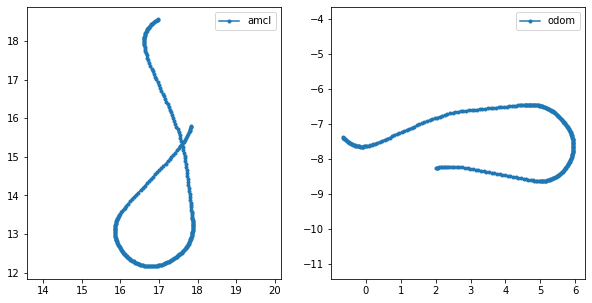

In [3]:
ground_truth = np.array([translation_from_matrix(d.ground_truth) for d in data])
measurement = np.array([translation_from_matrix(d.measurement) for d in data])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(ground_truth[:, 0], ground_truth[:, 1], '.-', label='amcl')
ax.legend();
ax.axis('equal');

ax = fig.add_subplot(1, 2, 2)
ax.plot(measurement[:, 0], measurement[:, 1], '.-', label='odom');
ax.legend();
ax.axis('equal');

In [4]:
def pairs(seq):
    i = iter(seq)
    prev = next(i)
    for item in i:
        yield prev, item
        prev = item

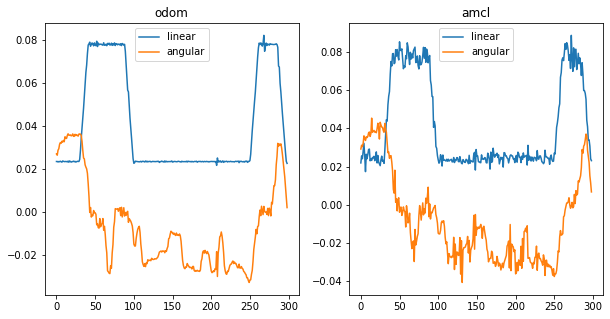

In [9]:
def inverse_odometry(m1, m2):
    delta_measurement = translation_from_matrix(m2) - translation_from_matrix(m1)
    r1 = euler_from_matrix(m1)[2]
    r2 = euler_from_matrix(m2)[2]

    R = np.linalg.lstsq([[sin(r2) - sin(r1)], [-cos(r2) + cos(r1)]], delta_measurement[:2], rcond=None)[0][0]
    angular = normalize_angle(r2 - r1)
    linear = R * angular
    
    return linear, angular

odom_commands = []

for d1, d2 in pairs(data):
    linear, angular = inverse_odometry(d1.measurement, d2.measurement)
    odom_commands.append((linear, angular))

odom_commands = np.array(odom_commands)

amcl_commands = []

for d1, d2 in pairs(data):
    linear, angular = inverse_odometry(d1.ground_truth, d2.ground_truth)
    amcl_commands.append((linear, angular))

amcl_commands = np.array(amcl_commands)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(odom_commands[:, 0], label='linear')
ax.plot(odom_commands[:, 1], label='angular')
ax.legend()
ax.set_title('odom')

ax = fig.add_subplot(1, 2, 2)
ax.plot(amcl_commands[:, 0], label='linear')
ax.plot(amcl_commands[:, 1], label='angular')
ax.legend();
ax.set_title('amcl');